# Excercise on Autoencoder and Variational Autoencoder

**Goal:** Aim of this excercise is to implement an Autoencoder (AE) and Variational Autoencoder (VAE) similar to the tutorial but this time for the sea level pressure in the North Atlantic. 


You will adapt the AE architecture of the tutorial to use Convolutional Neural Networks (CNN) and compare their performance. Furthermore, you will compare the latent space of the AE, VAE and PCA. Ideally you will identify the so called Northern Atlantic Oscillation (NAO), but more later ....

In [29]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy as ctp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

plt.style.use("./../paper.mplstyle")

## 1. Familierize yourself with the data

Sea level pressure (SLP) in the North Atlantic highly affects the climate over Europe. 

The monthly SLP data from 1950-1979 and 1979-2021 are taken from [Copernicus ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview). The data are cropped over the Northern Atlantic 20°-80°N, 90°W-40°E, regridded on a $5^\circ \times 5^\circ$ resolution, detrended and then subtracted from their monthly climatology. The data can be found in ```04_vae/data/slpa_...```.



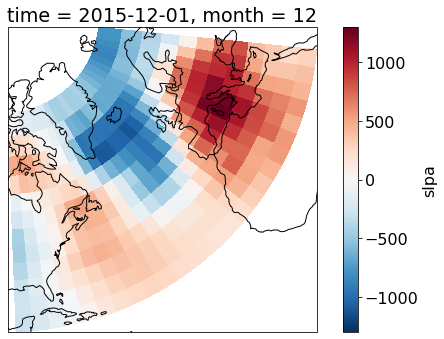

In [59]:
# Read data from file
da = xr.open_dataset("./data/slpa_1979_2021.nc")['slpa']

# Plot last year december, i.e. '2015-12'
map_proj = ctp.crs.LambertConformal()
p = da.sel(time='2015-12').plot(transform=ctp.crs.PlateCarree(), subplot_kws={'projection': map_proj})
p.axes.coastlines()

### The North Atlantic oscillation (NAO)

The NAO is a weather phenomenon over the North Atlantic Ocean characterized by differences in SLP between the Icelandic Low and the Azores high. The NAO can be either in positive or negative phase depending on the sign of the differences. [Wiki](https://en.wikipedia.org/wiki/North_Atlantic_oscillation)

There are different representative time-series of the NAO. One is based on pressure differences between certain points (Icelandic Low and the Azores high) the other is based on Principal Component Analysis. [ClimateDataGuide](https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-pc-based) 

***Exercise 1**: Construct the station-based NAO index, i.e. the SLP differences between Lisbon and Reykjavík.*

Tip:
- Select first only the winter months (Dec-Mar)
- Select the location of Lisbon and Reykjavik
- Normalize each time-series by its standard deviation
- Subtract the time-series from another 

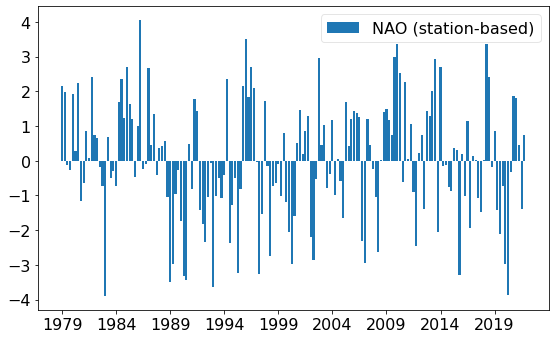

In [60]:
def select_months(dataarray, start_month = 12, end_month= 3):
    """Select data in month range.

    Args:
        dataarray (xr.DataArray): Dataarray input.
        start_month (int, optional): Number of start month. Defaults to 12.
        end_month (int, optional): Number of end month. Defaults to 3.
    """
    months = dataarray['time.month']
    if start_month <= end_month:
        mask = (months >= start_month) & (months <= end_month)
    else:
        mask = (months >= start_month) | (months <= end_month)
    
    return dataarray.sel(time=mask)

def normalize(da):
    """Normalize data by its standard deviation.


    Args:
        da (xr.DataArray): Input time-series.

    Returns:
        (xr.DataArray) Normalized time-series.
    """
    
    flatten = da.stack(z = da.dims)
    mean = flatten.mean(skipna=True)
    std = flatten.std(skipna=True)
    norm_da = (flatten - mean) / std 
    norm_da = norm_da.unstack('z')
    return norm_da

# Select only winte months
da_winter = select_months(da, start_month=12, end_month=3)

# Station based index
ts_rey = normalize(da_winter.sel(lat=64, lon=21, method='nearest'))
ts_lis = normalize(da_winter.sel(lat=38, lon=9, method='nearest'))
nao = ts_rey - ts_lis

# Plotting
fig, ax = plt.subplots()
ax.bar(np.arange(len(nao['time'])), height=nao.data, label='NAO (station-based)')
ticks = np.arange(0, len(nao['time']), 20)
ax.set_xticks(ticks=ticks)
ax.set_xticklabels(np.array(nao['time'][ticks], dtype='datetime64[Y]'))
ax.legend()


In [63]:
da[0].data[np.newaxis, ...].shape

(1, 12, 26)

## 2. Preprocess your data

As shown in the tutorial we need to define a Dataset class for training our Autoencoder. 

This time we want to train a Convolutional Neural Network as an encoder and decoder network. Therefore, we have to change our dataset class, such that our output of the _getitem_ function is of dimension (batch, 1, x_dim, y_dim). 

***Exercise 2**: Implement the dataset class such that we can train a CNN with it.*

In [65]:
class SLPA(Dataset):
    """Dataset of SSTA used for pytorch.

    Args:
        dataarray (xr.DataArray): Dataarray containing SSTA. 
    """
    def __init__(self, dataarray):
        self.time = dataarray['time'].data
        self.lat = dataarray['lat'].data
        self.lon = dataarray['lon'].data
        
        # Normalize dataarray by standard deviation
        self.dataarray = normalize(dataarray)
        

    def __len__(self):
        """Returns the number of datapoints."""
        return len(self.dataarray)
    

    def __getitem__(self, idx):
        """Required function to get items of dataset.

        Args:
            idx (int): Index to get datapoint.

        Returns:
            x (torch.Tensor): Datapoint
            l (dict): Label of datapoint. In this case just the index.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        x = torch.from_numpy(
            self.dataarray[idx].data[np.newaxis, ...]).float()
        label = {'idx': idx}

        return x, label
    
    def get_map(self, x, name=None):
        """Reshape flattened vector with removed NaNs to xarray map.

        Args:
            data (torch.tensor): (x_dim) Flatten datapoint with NaNs removed

        Return:
            map (np.ndarray): 2d-map
        """
        if torch.is_tensor(x):
            x = x.to('cpu').detach().numpy()
        
        if x.shape[0] == 1:
            x = x[0,:,:].copy()

        dmap = xr.DataArray(
            data=x,
            dims=['lat', 'lon'],
            coords=dict(lat=self.lat, lon=self.lon)
        )
        return dmap 

Initialize our dataset.

In [71]:
dataset = SLPA(da)
# Sample datapoint
x, l = dataset[0]
print(f"Shape of datapoint: {x.shape}")

Shape of datapoint: torch.Size([1, 12, 26])


In [72]:
n_training = int(len(dataset) * 0.8)
(train_data, val_data) = torch.utils.data.random_split(dataset, [n_training, len(dataset) - n_training])

# Define data loader
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

## Autoencoder

In [ ]:
class CNNAE(nn.Module):
    """Auto encoder.

    Args:
        z_dim (int): Dimension of latent space. 
        encoder ([type]): Encoder NN.
        decoder ([type]): Decoder NN.
    """

    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.device = torch.device(
                'cuda' if torch.cuda.is_available() else 'cpu')
        
        self. encoder = nn.Sequential(
            nn.Linear(x_dim, 512),
            nn.ReLU(),
            nn.Linear(512, z_dim),
        ).to(self.device)

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.ReLU(),
            nn.Linear(512, x_dim),
        ).to(self.device)

    
    def forward(self, x):
        """Pass through encoder and decoder.
        
        Args:
            x (tensor): (batch, x_dim) Input to AE.
        
        Return:
            x_hat (tensor): (batch, x_dim ) Reconstruction of x.
            z (tensor): (batch, z_dim) Vector in latent space.
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat, z
    
    def loss(self, x):
        """Loss function of AE.

        Args:
            x (torch.Tensor): (batch, x_dim) Input to AE.

        Returns:
            rec_loss (torch.Tensor): Reconstruction loss between input and rec.
        """
        
        # Encode and decoder input 
        x_hat, z = self.forward(x)
        # Mean square error between reconstructed and input
        rec_loss_pointwise = F.mse_loss(x_hat, x, reduction='none')
        # Sum of point wise MSE
        rec_loss = torch.sum(torch.flatten(rec_loss_pointwise, start_dim=1), dim=-1)
        
        return rec_loss.mean()

In [ ]:
import climvae.utils.
arch = nnarch.conv_arch(
        x_dim, z_dim=config['zdim'],
        kernel=[[4, 4], [4, 4]],  # , [4,4], [4,4]],
        stride=[[2, 2], [2, 2]],  # , [2,2], [2,2]],
        padding=[[1, 0], [0, 1]],  # , [0,0], [0,0]],
        channels=[8, 16]
    )